In [1]:
from google.colab import drive
import os
import sys
from collections import OrderedDict
import pickle
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/Project/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
# !python -m pip install -U matplotlib
!pip install tweet-preprocessor
!pip install matplotlib==3.1.3
!pip install transformers
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install librosa soundfile numpy sklearn pyaudio
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds
from transformers import TFRobertaForSequenceClassification
from transformers import RobertaTokenizer
import os
import yaml
from datetime import datetime

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline
import warnings
warnings.filterwarnings("ignore")


# Exploratory Data analysis for MELD Dataset

---



In [3]:
#load meld text data 
train = pd.read_csv("train_sent_emo.csv")
test = pd.read_csv("test_sent_emo.csv")
validation = pd.read_csv("dev_sent_emo.csv")

#adding all data together
train = train.append(test, ignore_index=True)
train = train.append(validation, ignore_index=True)

In [4]:

# add time of clips to dataset
train['time'] = 0
for i in range(len(train['StartTime'])):
    train['time'][i] = (datetime.strptime(train['EndTime'][i], '%H:%M:%S,%f')- datetime.strptime(train['StartTime'][i], '%H:%M:%S,%f')).total_seconds() #.timestamp()


In [5]:
print("MEAN of time of clips: ",np.asarray(train['time']).mean())
print("STD DEV of the time clips: ",np.asarray(train['time']).std())

MEAN of time of clips:  2.6996644295302015
STD DEV of the time clips:  4.049883354316501


GET BIN OF MELD EMOTIONS

In [6]:
unique = train.Emotion.unique()
e = [[] for i in range(len(unique))]
ecnt = [0 for i in range(len(unique))]
for i,val in enumerate (unique):
    for k in range(len(train['Emotion'])):
        if train['Emotion'][k]==val:
            e[i].append(train['Utterance'][k])
            ecnt[i]+=1

print("data bins:")
for i,val in enumerate(unique):
    print(f'{val}:{ecnt[i]}')

data bins:
neutral:6436
surprise:1636
fear:358
sadness:1002
joy:2308
disgust:361
anger:1607


neutral


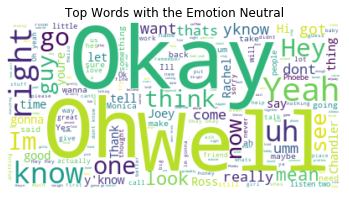

surprise


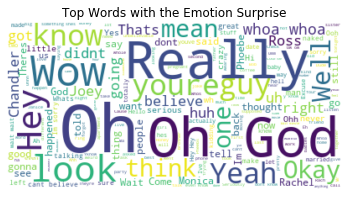

fear


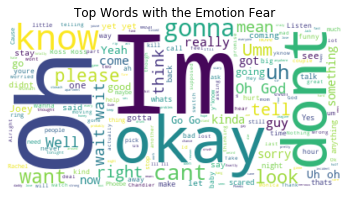

sadness


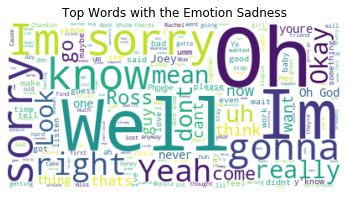

joy


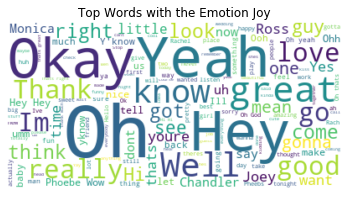

disgust


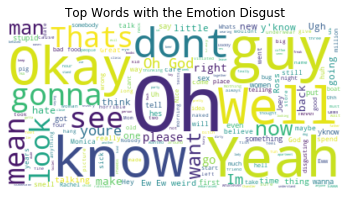

anger


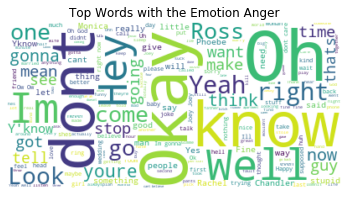

In [7]:
clouds = []

for i in range(len(unique)):
    print(unique[i])
    wordcloud = WordCloud(background_color='white').generate(' '.join(e[i]).replace("\x92",""))
    # Display the generated image:
    plt.title(f"Top Words with the Emotion {unique[i].capitalize() }")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [8]:
import itertools

merged = list(itertools.chain(*e))
bins = {}
for i,val in enumerate(merged):
    merged[i]=val.replace("\x92","")
    res = len(merged[i].split())
    
    if res in bins:
        bins[res]+=1
    else:
        bins[res]=1



In [9]:
for i in range(len(e)):
    print(unique[i],len(e[i]))

neutral 6436
surprise 1636
fear 358
sadness 1002
joy 2308
disgust 361
anger 1607


In [10]:
un = train['Speaker'].unique()
vals = {}
cont = {}
for i,val in enumerate(un):
    speaker = val
    data = train.loc[train['Speaker'] == val]
    vals[speaker] = data
    # print(speaker, len(data['Speaker']))
    cont[speaker] = len(data['Speaker'])

PersonList = sorted(cont.items(), key=lambda cont: cont[1], reverse=True)


In [11]:
print("number of unique characthers: ",len(train['Speaker'].unique()))

number of unique characthers:  304


In [12]:
print("top lines by actors",PersonList[:6])

top lines by actors [('Joey', 2069), ('Ross', 2049), ('Rachel', 1955), ('Phoebe', 1797), ('Monica', 1782), ('Chandler', 1763)]


In [13]:
total = len(train['Speaker'])
cn80 = 0
for i in range(0,6):
    cn80 += PersonList[i][1]

total = len(train['Speaker'])
ratio = cn80/total
left = total-cn80
print(total)

13708


In [14]:
 dataleft = total - int(0.95*total)

In [15]:
tot80=6
print("charachter bins")

print(tot80,cn80)

count20=0
tot20 = 0
for i in PersonList[6:]:
    if i[1] > 20:
        tot20+=1
        count20+=i[1]

totall=6+tot20
print(tot20,count20)
count10=0
tot10 = 0
for i in PersonList[totall:]:
    if i[1] > 10:
        tot10+=1
        count10+=i[1]

totall+=tot10
print(tot10,count10)
count5=0

tot5 = 0
for i in PersonList[totall:]:
    if i[1] > 5:
        tot5+=1
        count5+=i[1]
totall+=tot5
print(tot5,count5)
count0=0
tot0 = 0
for i in PersonList[totall:]:
    if i[1] > 0:
        tot0+=1
        count0+=i[1]
    
print(tot0,count0)

x = [cn80, count20, count10,count5,count0]
bins = ['90+','20-89','10-19','5-9','1-4']
number = [tot80,tot20,tot10,tot5,tot0]

charachter bins
6 11415
26 952
39 551
45 356
188 434


# number of lines spoken by charachters

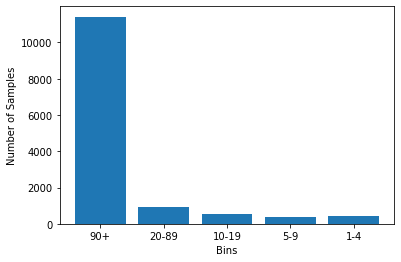

In [16]:
plt.bar(bins,x)
plt.xlabel('Bins')
plt.ylabel('Number of Samples')
plt.show()


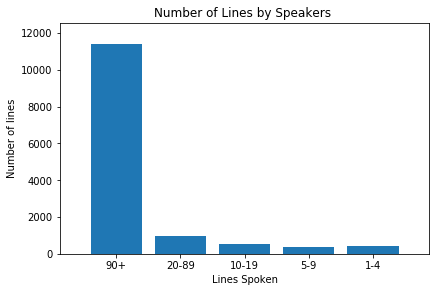

In [18]:
fig, ax = plt.subplots()
one = ax.bar(bins, x, label='Number of')

  
plt.xlabel('Lines Spoken')
plt.ylabel('Number of lines')
# ax.bar_label(one, labels=number,padding=3)

ax.set_title('Number of Lines by Speakers ')

plt.tight_layout(pad=0.5)
plt.margins(0.1)

plt.show()


# Charachter legnth Bins

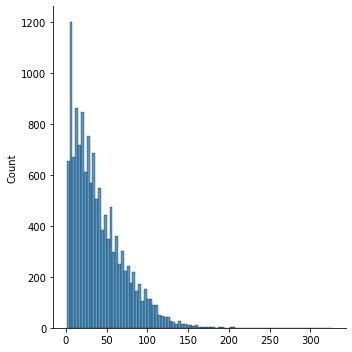

In [19]:
import statistics 
import seaborn as sns
import nltk
import preprocessor as p


allll_text = []
alll_len = []
all_seperate = []
bigrams = []
wods =[]
for i in range(len(train['Utterance'])):
    k = p.clean(train['Utterance'][i].lower())
    
    allll_text.append(k)
    alll_len.append(len(k))
    all_seperate+=k.split()
    wods.append(len(k.split()))
    # bigrams.append()
    gr = list(nltk.bigrams(k.split()))
    for i in gr:
        bigrams.append(f'{i[0]} {i[1]}')


statistics.mean(alll_len)
statistics.stdev(alll_len)

# sns.displot(, x="Word_distrbution", bins=20)
sns.displot(alll_len)

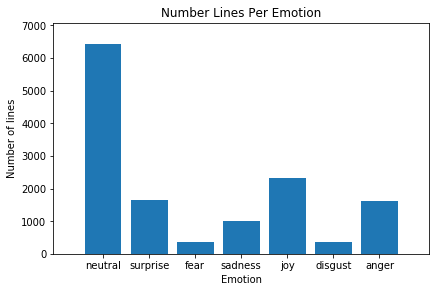

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
one = ax.bar(unique,ecnt , label='Number of')

plt.xlabel('Emotion')
plt.ylabel('Number of lines')
# ax.bar_label(one,padding=3)

ax.set_title('Number Lines Per Emotion')

plt.tight_layout(pad=0.5)
plt.margins(0.1)
plt.show()
